# Milestone P4 - Creative extension

In [1]:
#import libraries to use dataframes and basic feartures
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#logistic regression
from sklearn.linear_model import LogisticRegression, LinearRegression

#tool for predictio analysis
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import auc as computeAUC
from sklearn.model_selection import KFold

#Radom Forest & Gradient boosting
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.datasets import make_classification
from sklearn.inspection import permutation_importance

In [2]:
#Import the datasets
#Civil War Dataset (CWD)
DATA_FOLDER = 'data/'
DATASET = DATA_FOLDER+"SambnisImp.csv"

#Terrorism dataset
DATASET_TERROR = DATA_FOLDER+"globalterrorismdb_0919dist.xlsx"
DATASET_CID = DATA_FOLDER+"Sambanis_cid.dta"

#Opening and loading of files
df = pd.read_csv(DATASET, error_bad_lines=False, warn_bad_lines=True)
df_t = pd.read_excel(DATASET_TERROR, error_bad_lines=False, warn_bad_lines=True)
df_t = df_t.set_index('eventid')

#Loading the cowcode dataframe
cow = pd.read_csv('data/COW country codes.csv')

In [3]:
#Reduction of the CWD to 91 variables + years + cow code
doc = df[["warstds", "year", "cowcode", "ager", "agexp", "anoc", "army85", "autch98", "auto4",
    "autonomy", "avgnabo", "centpol3", "coldwar", "decade1", "decade2",
    "decade3", "decade4", "dem", "dem4", "demch98", "dlang", "drel", "durable",
    "ef", "ef2", "ehet", "elfo", "elfo2", "etdo4590", "expgdp", "exrec",
    "fedpol3", "fuelexp", "gdpgrowth", "geo1", "geo2", "geo34", "geo57",
    "geo69", "geo8", "illiteracy", "incumb", "infant", "inst", "inst3", "life",
    "lmtnest", "ln_gdpen", "lpopns", "major", "manuexp", "milper", "mirps0",
    "mirps1", "mirps2", "mirps3", "nat_war", "ncontig", "nmgdp", "nmdp4_alt",
    "numlang", "nwstate", "oil", "p4mchg", "parcomp", "parreg", "part",
    "partfree", "plural", "plurrel", "pol4", "pol4m", "pol4sq", "polch98",
    "polcomp", "popdense", "presi", "pri", "proxregc", "ptime", "reg",
    "regd4_alt", "relfrac", "seceduc", "second", "semipol3", "sip2", "sxpnew",
    "sxpsq", "tnatwar", "trade", "warhist", "xconst"]]

In [4]:
#Creating dataframes according to the parameters that were taken into account by the different papers

#Fearon and Laitin (2003)
df2003 = doc [["warhist", "ln_gdpen", "lpopns", "lmtnest",
    "ncontig", "oil", "nwstate", "inst3", "pol4", "ef", "relfrac"]]

#Collier and Hoeffler (2004)
df2004 = doc[["sxpnew", "sxpsq", "ln_gdpen", "gdpgrowth",
    "warhist", "lmtnest", "ef", "popdense", "lpopns", "coldwar", "seceduc",
    "ptime"]]

#Hegre and Sambanis (2006)
df2006 = doc[["lpopns", "ln_gdpen", "inst3", "parreg", "geo34",
    "proxregc", "gdpgrowth", "anoc", "partfree", "nat_war", "lmtnest",
    "decade1", "pol4sq", "nwstate", "regd4_alt", "etdo4590", "milper", "geo1",
    "tnatwar", "presi"]]

In [32]:
#Setting the y parameter wich is the occurence of a civil war => warstds
y = doc["warstds"]

In [6]:
#Function that will plot ROC curves of different sets of data that have undergo a n fold cross validation
#The variable: model is the classifier or model that we want to observe
#Each is a variable that allow the plot of every ROC curves
def rocList(model,Xs,Ys,n=10,labels = [] ,each=False,newplot=True,displaymean = True):
    
    means_x=[]
    means_y=[]
    means_auc=[]
    for j in range(len(Ys)) :
        x=Xs[j]
        y=Ys[j]
    
        #Objects to store the calculated tpr (true positive rate), fpr(false positive rate) and auc (area under curve)
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        kf = StratifiedKFold(n_splits=n)
        kf.split(x,y) 

        #fig, ax = plt.subplots(figsize=(10,10))

        #For each fold, calculate the ROC-parametres (tpr, fpr and auc) and plot
        for i, (train_index, test_index) in enumerate(kf.split(x,y)):
            X_train, X_test = x.iloc[train_index], x.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            classifier  = model.fit(X_train, y_train)
            clf.fit(X_train,y_train)
            predictions = clf.predict_proba(X_test)[:,-1]
            falseRate, trueRate, threshold = metrics.roc_curve(y_test, predictions)
            interp_tpr = np.interp(mean_fpr, falseRate, trueRate)            
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            #aucs.append( metrics.auc(falseRate, trueRate) )
            #aucs.append( metrics.roc_auc_score(y_test, predictions) )

        #Calculate the mean and standard deviation of ROC-parametres
        mean_tpr = np.nanmean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = computeAUC(mean_fpr, mean_tpr)
        #std_auc = np.nanstd(aucs)
        
        means_x.append(mean_fpr)
        means_y.append(mean_tpr)
        means_auc.append(mean_auc)
        
        if(each):
            plt.figure(figsize=(10,10))
            #plt.plot([0, 1], [0, 1], linestyle='-', lw=2, color='k',
            #    label='Chance', alpha=.8)
            plt.plot(mean_fpr, mean_tpr, color='b',
                #label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                lw=2, alpha=.8)
            std_tpr = np.std(tprs, axis=0)
            tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
            tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
            plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                        label=r'$\pm$ 1 std. dev.')
            plt.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
                   title="")
            plt.legend(loc="lower right")
            plt.show()
    
    if(len(labels)!=len(means_x)):
        labels = ['']*len(means_x)
    
    if (newplot): 
        plt.figure(figsize=(15,10))
    plt.title("Comparison of predictions from different datasets with a ROC plot")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    #plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)

    for i in range(len(means_x)):
        plt.plot(means_x[i],means_y[i],alpha = 0.8,label= labels[i] +' AUC: ' + str(round(means_auc[i],3)))
    over_x = np.mean( means_x ,axis = 0 )
    over_y = np.mean( means_y ,axis = 0 )
    if (displaymean): plt.plot( over_x , over_y , 'k--' , label = 'Global Mean , AUC: ' + str(round(metrics.auc(over_x, over_y),3))  )
    plt.legend()

In [7]:
#create a column of the evolution of a feature (must be numbers) by country, year to year
#return vector of this evolution --> df['feature']= computeEvol(df,feature)
#needs the column 'year' & 'cowcode'
def computeEvol(df,feature):
    cow = df['cowcode'].unique()
    relative=[0]*len(df)
    for country in cow:
        tabCountry = df[ df['cowcode']==country ].sort_values(by='year')
        for year in tabCountry['year'].unique()[1:]:
            before = tabCountry[ tabCountry['year'] == year-1 ][feature].values[0]
            after = tabCountry[ tabCountry['year'] == year ][feature].values[0]
            if(before==0):
                ratio = 0
            else:ratio = (after-before)/before
            ind=df.loc[ (df['year'] == year) & (df['cowcode'] == country) ].index.values[0] 
            relative[ind]=ratio
    return relative

## Part One

In [8]:
#The goal of this cell is to add a columns with the name of the country then to introduce the terrorism data
#Note: we can then drop StateName column
#dropuseless column and change names of the 2 remaining
cow=cow.drop(['StateAbb'],axis=1)
cow.columns = ['cowcode','country']
#merge it to doc (into doc_t) that now have a column 'StateName' matching cow code
doc_t = doc.merge(cow)
#doc_t.head()

In [9]:
#Get a list of country and their code (index) for the terrorism dataset
country = df_t[["country", "country_txt"]]
maxval = df_t['country'].max()
print("Total number of countries in the dataset : " + str(maxval))

lst=[]
for i in range(maxval):
    temp = country[country.country == i]
    if(not temp.empty):
        temp1=country[country.country == i].iloc[0]
        lst.append(temp1.country_txt)
    else:
        #not a country
        lst.append("NAC")
countrylist = pd.DataFrame(lst)
#countrylist.shape

Total number of countries in the dataset : 1004


In [10]:
#Calculate number of terrorist attacks in each country for each year. Final dataframe is fy1 which contains all years from
#1970 to 2000 with all countries and their number of terrorist attacks
#new = df_t[(df_t.country == 200)]
#new.head()
#import sys
first = df_t[df_t['iyear']==1970]
#nb = len(df_t[(df_t.iyear==1970 & df_t.country == 200)])
fc = first[first['country']==200]
maxval = df_t['country'].max()
#print(maxval)
#create the index for each year from 1970 to 2000
fy = np.arange(1970, 2000, 1)
fy1 = pd.DataFrame(fy,columns=['year'])
fy1 = fy1.set_index('year')
#length = len(df_t[(df_t.country==1)])
#print(length)
for i in range(maxval):
    ls=[]
    for j in range(1970,2000):
        temp = df_t[(df_t.country==i)]
        temp2 = len(temp[(temp.iyear==j)])
        ls.append(temp2)
    fy1[i] = ls
    
fy1.columns = [countrylist[0]]
fy1.drop(list(fy1.filter(regex = 'NAC')), axis = 1, inplace = True)
#fy1.head()

In [11]:
#tmp is a vector of zeros
tmp = [0]*len(doc_t)
#we iterate on our dataframe (doc_t) and retrieve for each row the year and the country
#then if the values is present in fy1 (we verfy in index and column), the value is changed at the correspondign location in tmp
for index, row in doc_t.iterrows():
    year = row['year']
    country = row['country']
    if( (year in fy1.index) & (country in fy1.columns) ):
        tmp[index]= fy1.loc[year][country].values[0]
#finally tmp is placed in doc_t as terrorism column
doc_t['terrorism']=tmp
doc_t=doc_t.drop(['country'],axis=1)
#doc_t.head()

In [12]:
'''newdoc_t = doc_t[["warstds", "year", "cowcode", "ager", "agexp", "anoc", "army85", "autch98", "auto4",
    "autonomy", "avgnabo", "centpol3", "coldwar", "decade1", "decade2",
    "decade3", "decade4", "dem", "dem4", "demch98", "dlang", "drel", "durable",
    "ef", "ef2", "ehet", "elfo", "elfo2", "etdo4590", "expgdp", "exrec",
    "fedpol3", "fuelexp", "gdpgrowth", "geo1", "geo2", "geo34", "geo57",
    "geo69", "geo8", "illiteracy", "incumb", "infant", "inst", "inst3", "life",
    "lmtnest", "ln_gdpen", "lpopns", "major", "manuexp", "milper", "mirps0",
    "mirps1", "mirps2", "mirps3", "nat_war", "ncontig", "nmgdp", "nmdp4_alt",
    "numlang", "nwstate", "oil", "p4mchg", "parcomp", "parreg", "part",
    "partfree", "plural", "plurrel", "pol4", "pol4m", "pol4sq", "polch98",
    "polcomp", "popdense", "presi", "pri", "proxregc", "ptime", "reg",
    "regd4_alt", "relfrac", "seceduc", "second", "semipol3", "sip2", "sxpnew",
    "sxpsq", "tnatwar", "trade", "warhist", "xconst", "terrorism"]]'''

'newdoc_t = doc_t[["warstds", "year", "cowcode", "ager", "agexp", "anoc", "army85", "autch98", "auto4",\n    "autonomy", "avgnabo", "centpol3", "coldwar", "decade1", "decade2",\n    "decade3", "decade4", "dem", "dem4", "demch98", "dlang", "drel", "durable",\n    "ef", "ef2", "ehet", "elfo", "elfo2", "etdo4590", "expgdp", "exrec",\n    "fedpol3", "fuelexp", "gdpgrowth", "geo1", "geo2", "geo34", "geo57",\n    "geo69", "geo8", "illiteracy", "incumb", "infant", "inst", "inst3", "life",\n    "lmtnest", "ln_gdpen", "lpopns", "major", "manuexp", "milper", "mirps0",\n    "mirps1", "mirps2", "mirps3", "nat_war", "ncontig", "nmgdp", "nmdp4_alt",\n    "numlang", "nwstate", "oil", "p4mchg", "parcomp", "parreg", "part",\n    "partfree", "plural", "plurrel", "pol4", "pol4m", "pol4sq", "polch98",\n    "polcomp", "popdense", "presi", "pri", "proxregc", "ptime", "reg",\n    "regd4_alt", "relfrac", "seceduc", "second", "semipol3", "sip2", "sxpnew",\n    "sxpsq", "tnatwar", "trade", "warhist", "xconst", 

### terrorism study

In [18]:
#compute terrorism evolution
doc_t2 = doc_t.copy()
doc_t2['evolterrorism']= computeEvol(doc_t2,'terrorism')

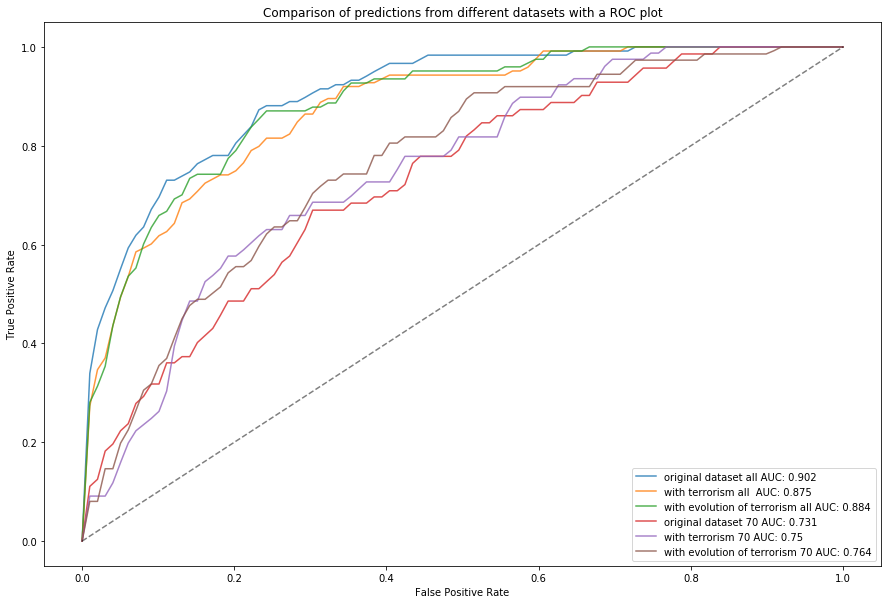

In [23]:
clf = RandomForestClassifier(n_estimators=100, max_depth=10)

#original data set
X = doc.drop( ["warstds", "year", "cowcode"] , axis=1 )
y = doc['warstds']
#terrorism data set
X_t = doc_t.drop( ["warstds", "year", "cowcode"] , axis=1 )
y_t = doc_t['warstds']

#original data set from 1970
X70 = doc[ doc['year'] >= 1970 ].drop( ["warstds", "year", "cowcode"] , axis=1 )
y70 = doc[ doc['year'] >= 1970 ]['warstds']
#terrorism data set from 1970
X_t70 = doc_t[ doc_t['year'] >= 1970 ].drop( ["warstds", "year", "cowcode"] , axis=1 )
y_t70 = doc_t[ doc_t['year'] >= 1970 ]['warstds']

##test with terrorism evolution
#terrorism data set with terrorism evolution
X_t_ev = doc_t2.drop( ["warstds", "year", "cowcode",'terrorism'] , axis=1 )
y_t_ev = doc_t2['warstds']

#same from 1970
X_t_ev70 = doc_t2[ doc_t2['year'] >= 1970 ].drop( ["warstds", "year", "cowcode",'terrorism'] , axis=1 )
y_t_ev70 = doc_t2[ doc_t2['year'] >= 1970 ]['warstds']

Xs = [ X , X_t, X_t_ev , X70 , X_t70 ,X_t_ev70 ,  ]
Ys = [ y , y_t, y_t_ev , y70 , y_t70 ,y_t_ev70 ,  ]

labs =['original dataset all','with terrorism all ', 'with evolution of terrorism all',
       'original dataset 70','with terrorism 70', 'with evolution of terrorism 70',
       ]

rocList(clf,Xs,Ys,n=10,labels = labs,displaymean = False)

plt.plot([0,1],[0,1],'k--',alpha=0.5)


In [27]:
##Gini Score ranking

#all years
X_t2 = doc_t2.drop( ["warstds", "year", "cowcode",] , axis=1 )
y_t2 = doc_t2['warstds']
clf.fit(X_t2,y_t2)
#then i match the feature with their importance (aka Gini Score) provided by the Random Forest object
testDF = pd.DataFrame ( { 'variables' : X_t2.columns ,
                          'importance': clf.feature_importances_  ,
                              }  )    
#i order the features according to their importance, and keep only the 20 best
testDF = testDF.sort_values(by=['importance'] , ascending=False)
testDF = testDF.reset_index() 
ind_ft = testDF.loc[ testDF['variables'] == 'terrorism'].index[0]
ind_evol = testDF.loc[ testDF['variables'] == 'evolterrorism'].index[0]

print( 'terrorism rank (all): '+str(ind_ft) )
print( 'evolterrorism rank (all): '+str(ind_evol) )

#1970-2000
X_t70 = doc_t2[ doc_t2['year'] >= 1970 ].drop( ["warstds", "year", "cowcode",] , axis=1 )
y_t70 = doc_t2[ doc_t2['year'] >= 1970 ]['warstds']

clf.fit(X_t70,y_t70)

#then i match the feature with their importance (aka Gini Score) provided by the Random Forest object
testDF = pd.DataFrame ( { 'variables' : X_t70.columns ,
                          'importance': clf.feature_importances_  ,
                              }  )
    
#i order the features according to their importance, and keep only the 20 best
testDF = testDF.sort_values(by=['importance'] , ascending=False)
testDF = testDF.reset_index()
    
ind_ft = testDF.loc[ testDF['variables'] == 'terrorism'].index[0]
ind_evol = testDF.loc[ testDF['variables'] == 'evolterrorism'].index[0]

print( 'terrorism rank (70): ' + str(ind_ft) )
print( 'evolterrorism rank (70): ' + str(ind_evol) )

## best rank for evolterrorism from 1970

terrorism rank (all): 25
evolterrorism rank (all): 23
terrorism rank (70): 22
evolterrorism rank (70): 8


In [38]:
#Splitting of the training set and testing set, Creation of the y training and y testing
#Removing of the "warstds" which is the variable we want to predict so it should be erased from the X training and X testing
#CWD
training_set,testing_set, y_train, y_test = train_test_split( doc.drop(["warstds", "year", "cowcode"],axis=1) , doc["warstds"], test_size=0.33,)
training_set_t,testing_set_t, y_train_t, y_test_t = train_test_split( doc_t.drop(["warstds", "year", "cowcode"],axis=1) , doc_t["warstds"], test_size=0.33,)

In [39]:
#Uncorrected Logistic regression with the parameters solver and max_iter because the number of iterations were not enough
#Fearon and Laitin (2003)
log2003 = LogisticRegression(penalty = 'none', solver='lbfgs', max_iter=1e9).fit(df2003,y)

#Collier and Hoeffler (2004)
log2004 = LogisticRegression(penalty = 'none', solver='lbfgs', max_iter=1e9).fit(df2004,y)

#Hegre and Sambanis (2006)
log2006 = LogisticRegression(penalty = 'none', solver='lbfgs', max_iter=1e9).fit(df2006,y)

#Creation of a Random Forest classifier with max_depth = 10 for CWD
clf = RandomForestClassifier(n_estimators=100, max_depth=10)

#Creation of a Gradient Boosting Classifier with the same variables as Random Forest
boostclf = GradientBoostingClassifier(n_estimators=100, max_depth=10)

#Creation of a Random Forest classifier with max_depth = 10 for CWD + TD
clf_t = RandomForestClassifier(n_estimators=100, max_depth=10)

#Creation of a Gradient Boosting Classifier with the same variables as Random Forest for CWD + TD

boostclf_t = GradientBoostingClassifier(n_estimators=100, max_depth=10)

In [40]:
#Fitting the RF model with the CWD training set
clf.fit(training_set, y_train)

#Fitting the GB model with the CWD training set
boostclf.fit(training_set, y_train)

#Fitting the RF model with the CWD + DT training set
clf_t.fit(training_set_t, y_train_t)

#Fitting the GB model with the CWD + DT training set
boostclf_t.fit(training_set_t, y_train_t)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=10,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [41]:
#Calculations of the estimates and the AUC score
#Fearon and Laitin (2003)
probs = log2003.predict_proba(df2003)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y, preds)
roc_auc = metrics.auc(fpr, tpr)

#Collier and Hoeffler (2004)
probs4 = log2004.predict_proba(df2004)
preds4 = probs4[:,1]
fpr4, tpr4, threshold4 = metrics.roc_curve(y, preds4)
roc_auc4 = metrics.auc(fpr4, tpr4)

#Hegre and Sambanis (2006)
probs6 = log2006.predict_proba(df2006)
preds6 = probs6[:,1]
fpr6, tpr6, threshold6 = metrics.roc_curve(y, preds6)
roc_auc6 = metrics.auc(fpr6, tpr6)

#Predictions with the testing set, calculations of the AUC scores for the RF model
probs0c = clf.predict_proba(testing_set)
preds0c = probs0c[:,1]
fpr0c, tpr0c, threshold0c = metrics.roc_curve(y_test, preds0c)
roc_auc0c = metrics.auc(fpr0c, tpr0c)

#Predictions with the testing set, calculations of the AUC scores for the GB model
probs0bc = boostclf.predict_proba(testing_set)
preds0bc = probs0bc[:,1]
fpr0bc, tpr0bc, threshold0bc = metrics.roc_curve(y_test, preds0bc)
roc_auc0bc = metrics.auc(fpr0bc, tpr0bc)

#Predictions with the testing set, calculations of the AUC scores for the RF model for CWD + TD
probs0c_t = clf_t.predict_proba(testing_set_t)
preds0c_t = probs0c_t[:,1]
fpr0c_t, tpr0c_t, threshold0c_t = metrics.roc_curve(y_test_t, preds0c_t)
roc_auc0c_t = metrics.auc(fpr0c_t, tpr0c_t)

#Predictions with the testing set, calculations of the AUC scores for CWD + TD
probs0bc_t = boostclf_t.predict_proba(testing_set_t)
preds0bc_t = probs0bc_t[:,1]
fpr0bc_t, tpr0bc_t, threshold0bc_t = metrics.roc_curve(y_test_t, preds0bc_t)
roc_auc0bc_t = metrics.auc(fpr0bc_t, tpr0bc_t)

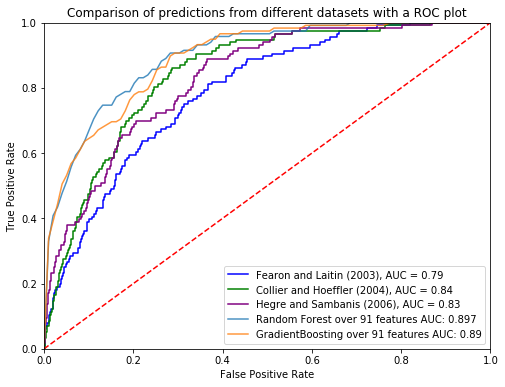

In [42]:
#Plotting of the curves with a red dashed line like in ROC plots
plt.figure(figsize = (8,6))
plt.title('Comparison of different models predictions')

#Plotting of the 3 LR models
plt.plot(fpr, tpr, 'b', label = 'Fearon and Laitin (2003), '+'AUC = ' + '{:.2f}'.format(roc_auc)) 
plt.plot(fpr4, tpr4, 'green', label = 'Collier and Hoeffler (2004), '+'AUC = ' + '{:.2f}'.format( roc_auc4))
plt.plot(fpr6, tpr6, 'purple', label = 'Hegre and Sambanis (2006), '+'AUC = ' + '{:.2f}'.format( roc_auc6)) 

#Plotting of the RF and GB models
rocList(clf,[doc.drop(["warstds", "year", "cowcode"],axis=1)] , [doc["warstds"]], labels = ['Random Forest over 91 features'], newplot = False, displaymean = False)
rocList(boostclf,[doc.drop(["warstds", "year", "cowcode"],axis=1)] , [doc["warstds"]], labels = ['GradientBoosting over 91 features'], newplot = False, displaymean = False)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [43]:
#Creating a Series of features importances or gini scores of the models (RF and GB)
feature_imp = pd.Series(clf.feature_importances_,index=training_set.columns).sort_values(ascending=False)
boost_feature_imp = pd.Series(boostclf.feature_importances_,index=training_set.columns).sort_values(ascending=False)

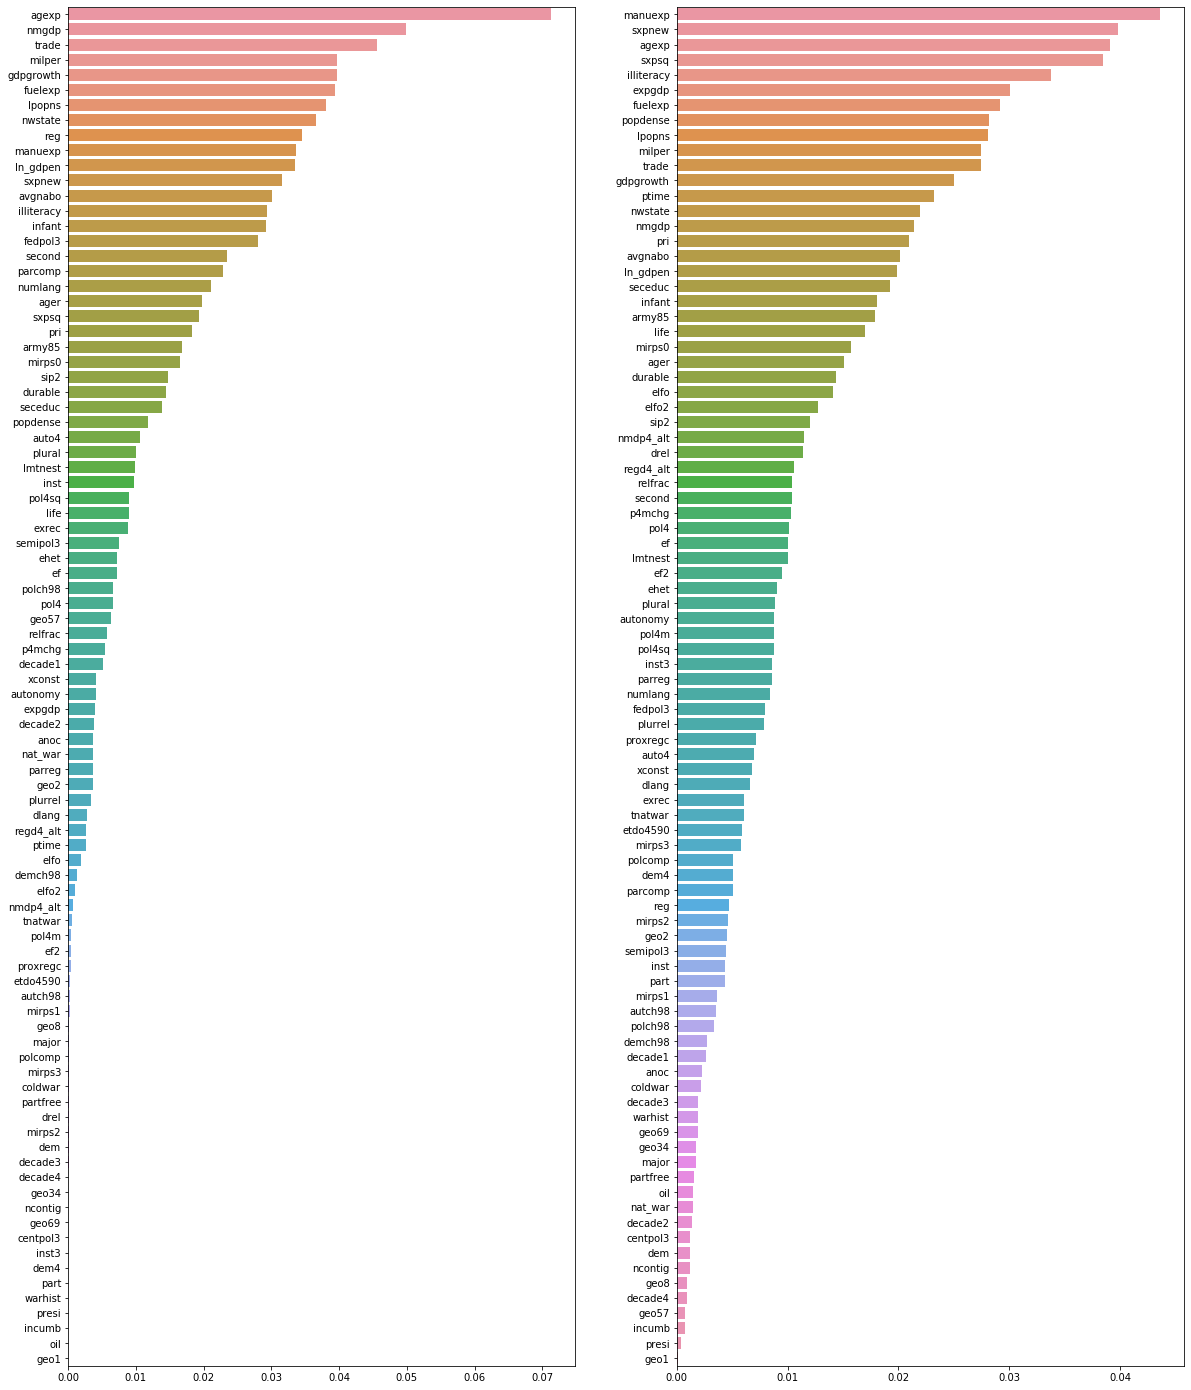

In [44]:
#Comparison of the features importance for the two models (RF and GB)
fig, ax = plt.subplots(1,2, figsize = (20,25))
#plt.figure(figsize = (20, 15))
sns.barplot(ax = ax[0],x=boost_feature_imp, y=boost_feature_imp.index)
# Add labels to your graph
#ax[0].xlabel('Feature Importance Score')
#ax[0].ylabel('Features')
#ax[0].title("Visualizing Important Features")
sns.barplot(ax = ax[1],x=feature_imp, y=feature_imp.index)
# Add labels to your graph
#ax[1].xlabel('Feature Importance Score')
#ax[1].ylabel('Features')
#ax[1].title("Visualizing Important Features")
#plt.show()

In [103]:
m1 = pd.DataFrame( feature_imp )
m2 = pd.DataFrame( boost_feature_imp ) 
merge = m1.merge(m2,left_index=True, right_index=True , )
merge.columns = ['Random Forest' , 'Gradient Boosting']
merge['tri']=merge['Random Forest']+merge['Gradient Boosting']

#merge=merge.sort_values(by=['Random Forest' , 'Gradient Boosting'], ascending=False)
merge=merge.sort_values(by=['tri'], ascending=False)

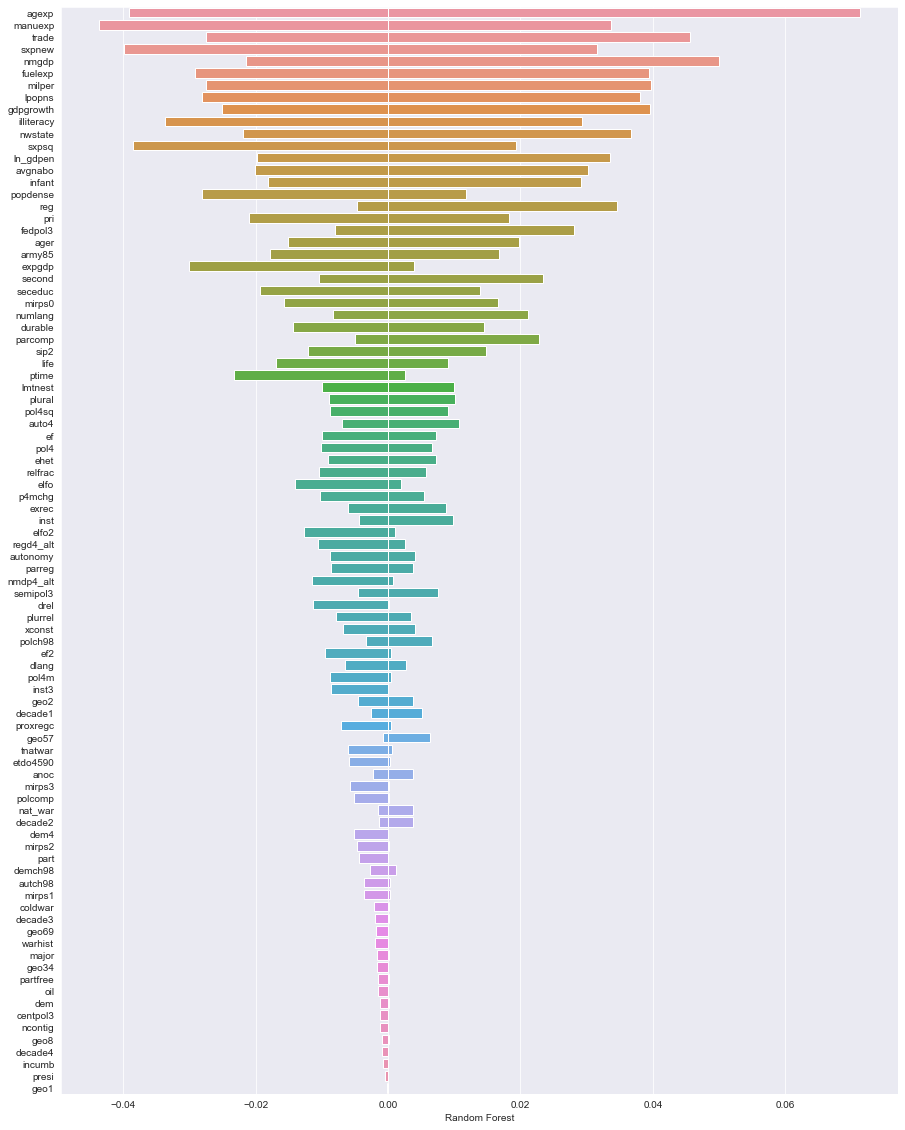

In [104]:
plt.figure(figsize=(15,20))
sns.set_style("darkgrid")



sns.barplot(x=merge['Gradient Boosting'], y=merge.index)

sns.barplot(x=-merge['Random Forest'], y=merge.index)

### classic vs terrorism

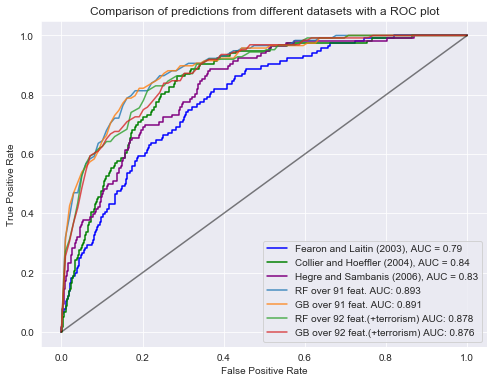

In [64]:
#ROC plots of the 3 LR, the RF and GB on CWD
#ROC plots of the RF and GB on CWD + TD
plt.figure(figsize = (8,6))
plt.title('Comparison of different models predictions')
plt.plot(fpr, tpr, 'b', label = 'Fearon and Laitin (2003), '+'AUC = ' + '{:.2f}'.format(roc_auc)) 
plt.plot(fpr4, tpr4, 'green', label = 'Collier and Hoeffler (2004), '+'AUC = ' + '{:.2f}'.format( roc_auc4))
plt.plot(fpr6, tpr6, 'purple', label = 'Hegre and Sambanis (2006), '+'AUC = ' + '{:.2f}'.format( roc_auc6)) 
rocList(clf,[doc.drop(["warstds", "year", "cowcode"],axis=1)] , [doc["warstds"]], labels = ['RF over 91 feat.'], newplot = False, displaymean = False)
rocList(boostclf,[doc.drop(["warstds", "year", "cowcode"],axis=1)] , [doc["warstds"]], labels = ['GB over 91 feat.'], newplot = False, displaymean = False)
rocList(clf_t,[doc_t.drop(["warstds", "year", "cowcode"],axis=1)] , [doc_t["warstds"]], labels = ['RF over 92 feat.(+terrorism)'], newplot = False, displaymean = False)
rocList(boostclf_t,[doc_t.drop(["warstds", "year", "cowcode"],axis=1)] , [doc_t["warstds"]], labels = ['GB over 92 feat.(+terrorism)'], newplot = False, displaymean = False)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],color='k--',alpha=0.5)
plt.show()

## Part Two

### Year

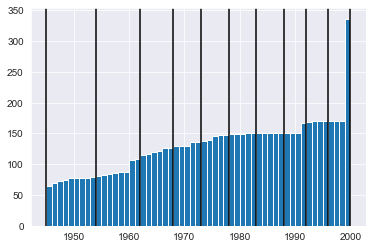

In [65]:
#Histogram to see the repartition of the values accross the years
#We see that there are twice as many variables in the 1990-2000 than in 1950-1960
doc['year'].hist(bins=55)
#quantiles, we can use then instead of period for slicing to have less unbalanced sub df
qt = doc['year'].quantile(np.arange(0,1.1,0.1))
for q in qt:
    plt.axvline(x=q,color='k')
    

In [106]:
#Dividing the Dataset into subsets according to a number of years (period)
period = 5
vecy=np.arange(1945,2000-period,period)
tab = []
for year in vecy:
    tab.append( doc[ (doc['year'] >= year) & (doc['year'] < year+period) ] )

tab.append(doc[ doc['year'] >= 2000-period ])

for i in range(len(tab)):
    tab[i] = tab[i].drop(['year','cowcode'] , axis='columns')
    print(len(tab[i]))
#pas de changement notable de la proportion total de cas civil war
#resultat non proportionel à la quantité de donnée

358
393
427
565
632
678
738
753
755
825
1016


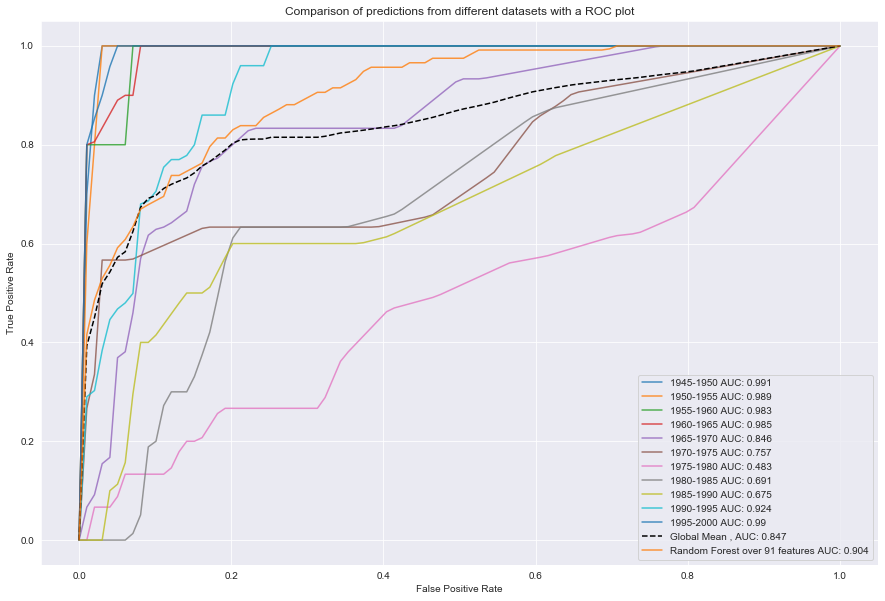

In [105]:
#Plotting of the ROC curve: means of the n cross-validation of each subset (period of time)
clf = RandomForestClassifier(n_estimators=100, max_depth=10)
xs=[]
ys=[]
for i in tab:
    ys.append( i['warstds'] )
    xs.append( i.drop(['warstds'],axis='columns') )
labs=[]
tmpvec = np.arange(1945,2000,period)
for year in tmpvec:
    labs.append( str(year)+'-'+str(year+period) )
#print(len(labs))
rocList(clf,xs,ys,n=5,labels=labs)

#rocList pour lsiser RF ?
#plt.plot(fpr0c, tpr0c, 'black', label = 'Random Forest over 91 features, '+'AUC = ' + '{:.2f}'.format( roc_auc0c))

rocList(clf,[doc.drop(["warstds", "year", "cowcode"],axis=1)] , [doc["warstds"]], labels = ['Random Forest over 91 features'], newplot = False, displaymean = False)

plt.legend()

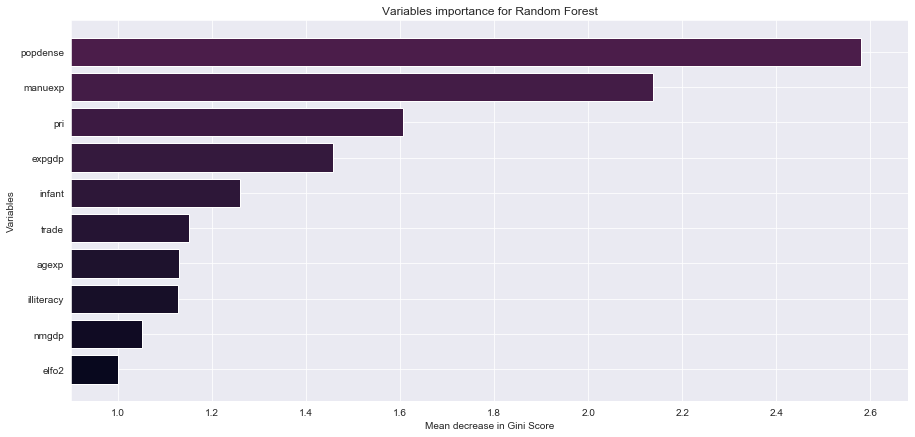

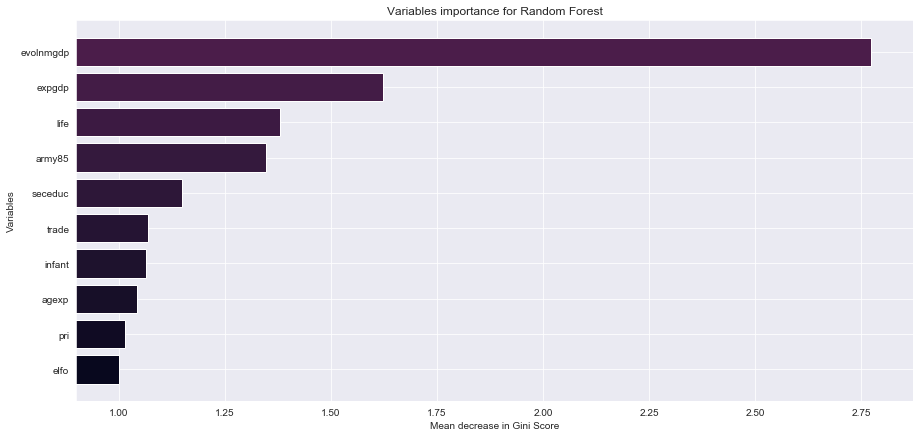

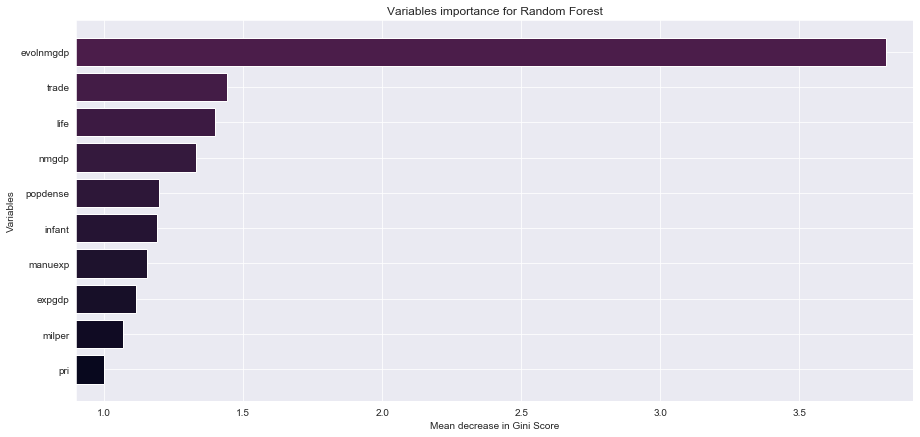

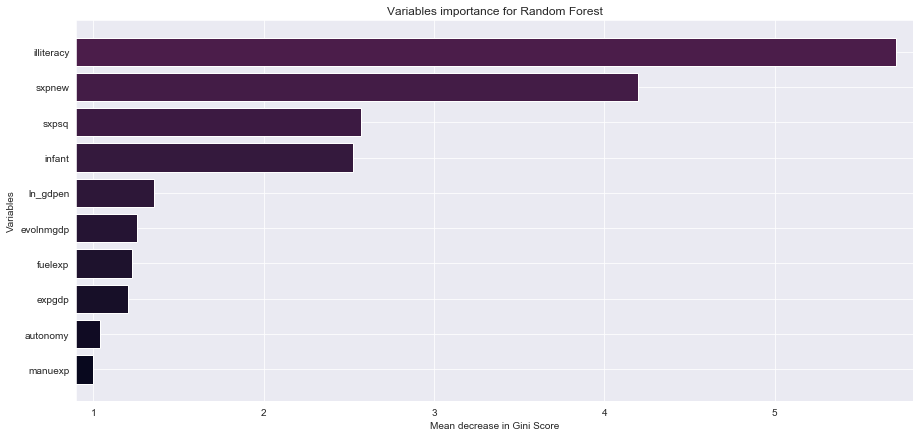

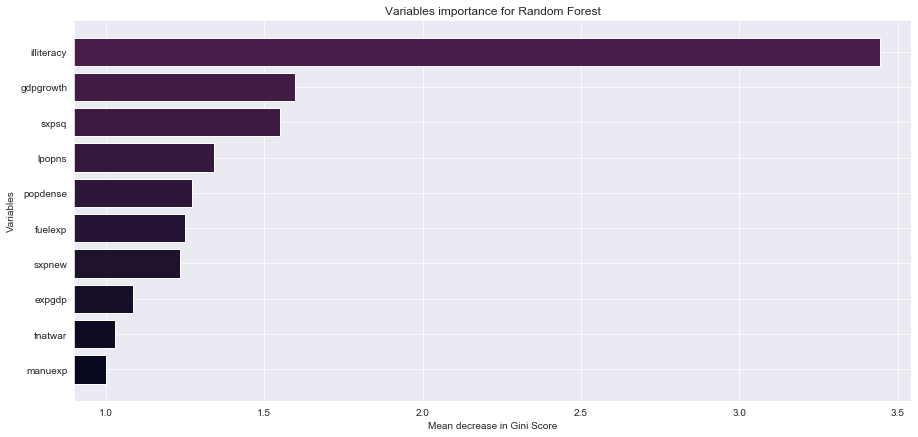

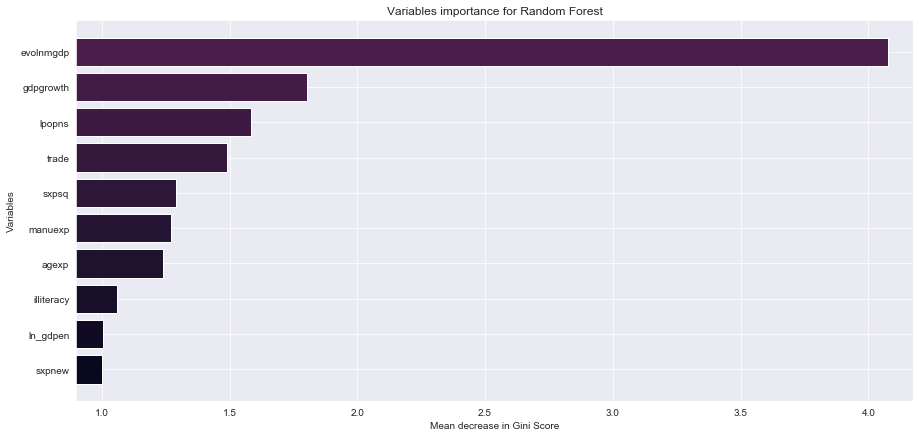

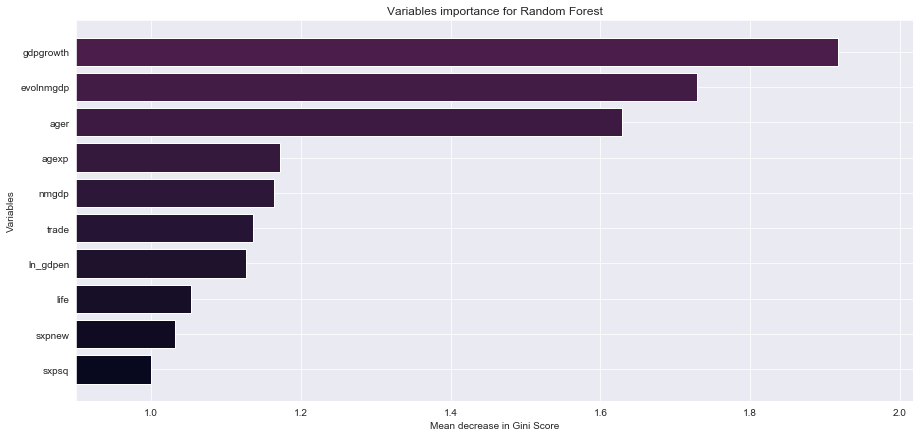

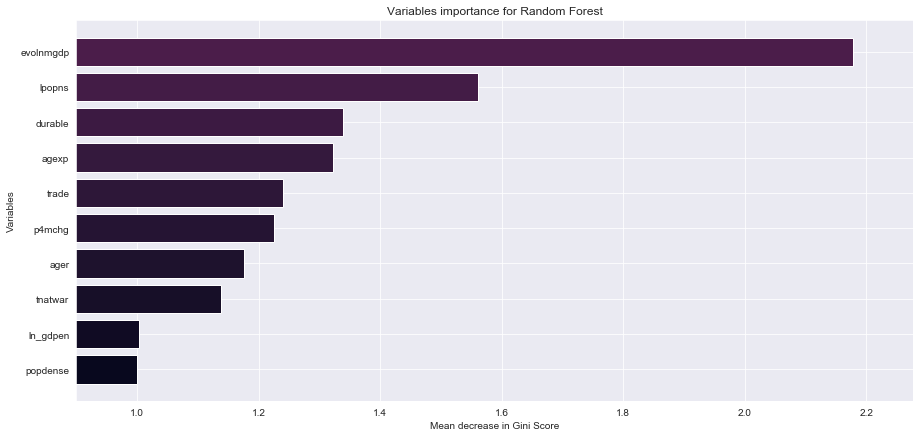

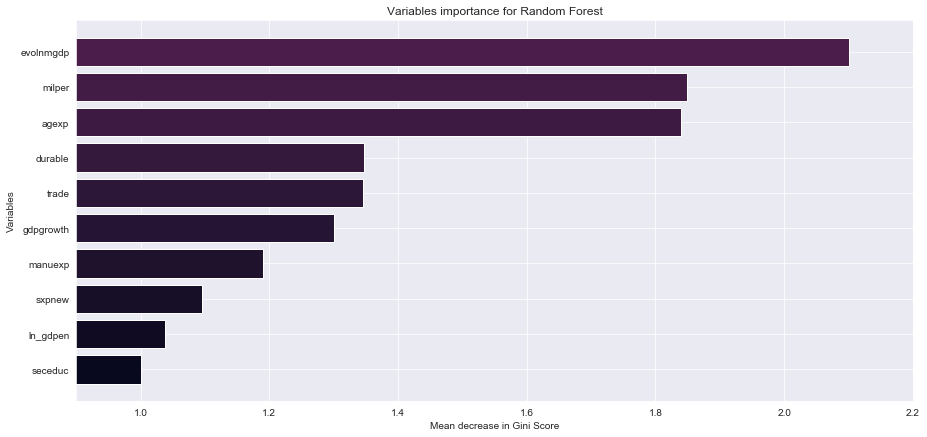

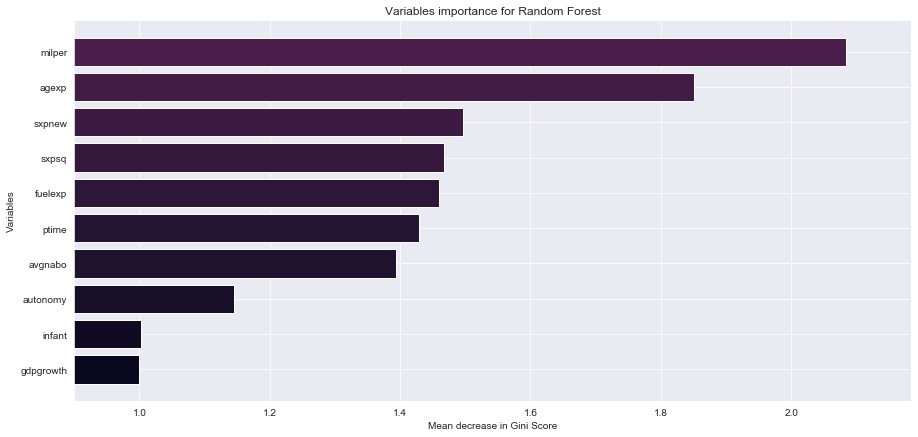

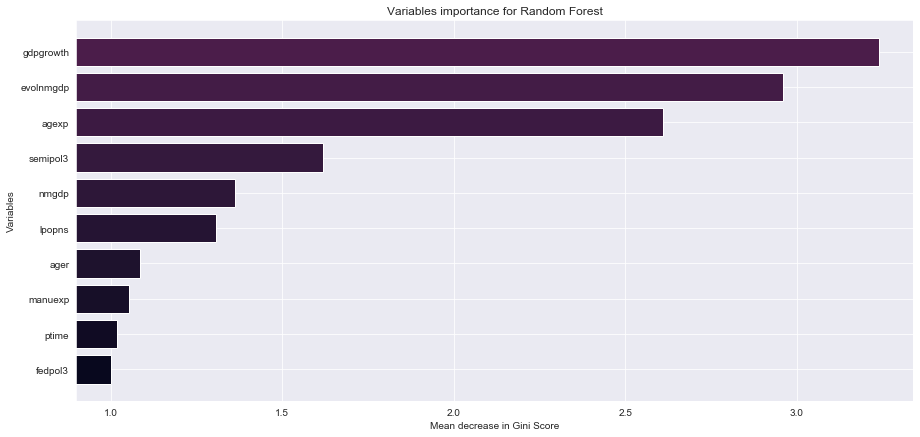

In [110]:
for i in range(len(xs)):
    X=xs[i]
    y=ys[i]
    clf.fit(X,y)
    #then i match the feature with their importance (aka Gini Score) provided by the Random Forest object
    testDF = pd.DataFrame ( { 'variables' : X.columns ,
                              'importance': clf.feature_importances_  ,
                              }  )
    #i order the features according to their importance, and keep only the 20 best
    testDF = testDF.sort_values(by=['importance'] , ascending=True)[-10:]

    #color for the graph, not improtant
    palette = sns.color_palette("rocket",n_colors = 50)

    #i do a bar plot with the gini score in X axis and name of the features on  Y axis
    #note : i 'normalize' the gini score obtained by the minimal value
    #i did this first by intuition looking at the original fiure as the gini score start to 1, and the result i obatined were very similar to the figure
    plt.figure(figsize=(15,7))
    plt.barh(testDF['variables'],testDF['importance']/testDF['importance'].min(),color = palette  )
    #i set the limit a bit further than the max and min value 
    plt.xlim([0.9,testDF['importance'].max()/testDF['importance'].min()+0.1])

    #set titles for the figure and the axis
    plt.title('Variables importance for Random Forest')
    plt.xlabel("Mean decrease in Gini Score")
    plt.ylabel("Variables")

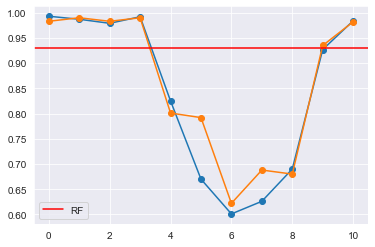

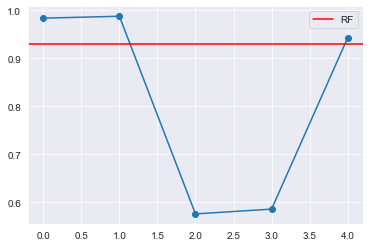

In [102]:
#5 ans
tab_auc=[ 0.993 , 0.987 , 0.979 , 0.992 , 0.825 , 0.67 , 0.601 , 0.626 , 0.690 , 0.927 , 0.984  ]
vec = np.arange(0,len(tab_auc),1)

plt.plot(vec,tab_auc,'o-')

tab_auc=[ 0.983 , 0.99 , 0.983 , 0.99 , 0.801 , 0.792 , 0.622 , 0.688 , 0.68 , 0.935 , 0.982 ]
vec = np.arange(0,len(tab_auc),1)

plt.plot(vec,tab_auc,'o-')

plt.axhline( y = 0.93 , color='r' ,label = 'RF') 
#plt.axhline( y = 0.843 , color='g' ,label = 'mean of years') 

plt.legend()

#11 ans
plt.figure()
tab_auc=[ 0.984 , 0.988 , 0.576 , 0.586 , 0.943  ]

vec = np.arange(0,len(tab_auc),1)

plt.plot(vec,tab_auc,'o-')
plt.axhline( y = 0.93 , color='r' ,label = 'RF') 
plt.legend()

### GDP per capita

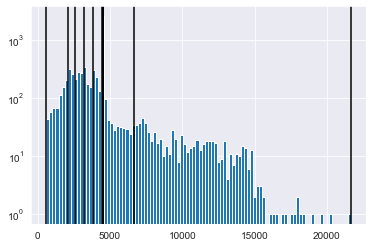

In [68]:
#Visualization of the repartition of the values according to GDP per capita
#We need to use quantiles
docbis = doc.copy()
doc['nmgdp'].hist(bins=100)
quantile = docbis['nmgdp'].quantile(np.arange(0,1.1,0.1))
for q in quantile:
    plt.axvline(x=q,color='k')
plt.yscale('log')

In [69]:
#Cutting the dataset into subsets by quantiles
quantile_nmgdp = docbis['nmgdp'].quantile(np.arange(0,1.1,0.1))
tab_nmgdp=[]
for i in range(10):
    tab_nmgdp.append( doc[ (docbis['nmgdp'] >= quantile_nmgdp.iloc[i]) & (doc['nmgdp'] < quantile_nmgdp.iloc[i+1]) ] )

for i in range(len(tab_nmgdp)):
    tab_nmgdp[i] = tab_nmgdp[i].drop(['year','cowcode'] , axis='columns')

In [70]:
for i in tab_nmgdp:
    print(len(i[i['warstds']==1]))

17
18
21
42
10
1
0
0
5
2


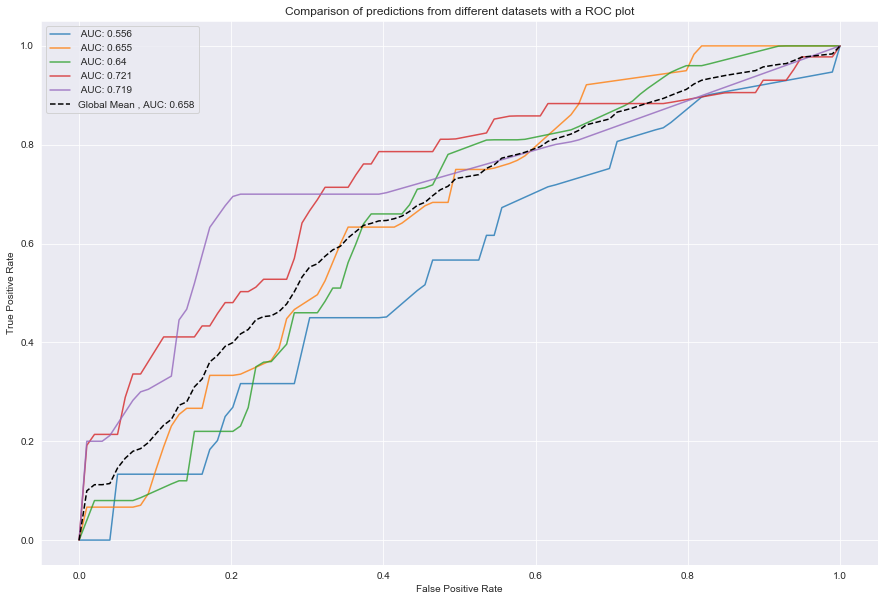

In [71]:
xs_nmgdp=[]
ys_nmgdp=[]
tab_nmgdp = tab_nmgdp[:5]
for i in tab_nmgdp:
    ys_nmgdp.append( i['warstds'] )
    xs_nmgdp.append( i.drop(['warstds'],axis='columns') )
#labs=[]
'''tmpvec = np.arange(1945,2000,period)
for year in tmpvec:
    labs.append( str(year)+'-'+str(year+period) )'''
#print(len(labs))
labs_nmgdp = ['1','2','3','4','5','6','7','8','9','10']
rocList(clf,xs_nmgdp,ys_nmgdp,n=5,labels=labs_nmgdp)
#plt.plot(fpr0c, tpr0c, 'black', label = 'Random Forest over 91 features, '+'AUC = ' + '{:.2f}'.format( roc_auc0c))
#plt.legend()

##rajouter diagonale

### GPD Growth

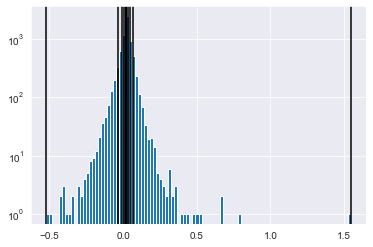

In [72]:
#Visualization of the repartition of the values according to GDP Growth
doc['gdpgrowth'].hist(bins=100)

quantile = doc['gdpgrowth'].quantile(np.arange(0,1.1,0.1))
for q in quantile:
    plt.axvline(x=q,color='k')

#log scale
plt.yscale('log')

In [73]:
#Cutting the dataset into subsets by quantile
quantile_gdpgrowth = docbis['gdpgrowth'].quantile(np.arange(0,1.1,0.1))
tab_gdpgrowth=[]
for i in range(10):
    tab.append( doc[ (docbis['gdpgrowth'] >= quantile_gdpgrowth.iloc[i]) & (doc['gdpgrowth'] < quantile_gdpgrowth.iloc[i+1]) ] )

for i in range(len(tab_gdpgrowth)):
    tab_gdpgrowth[i] = tab_ngdpgrowth[i].drop(['year','cowcode'] , axis='columns')

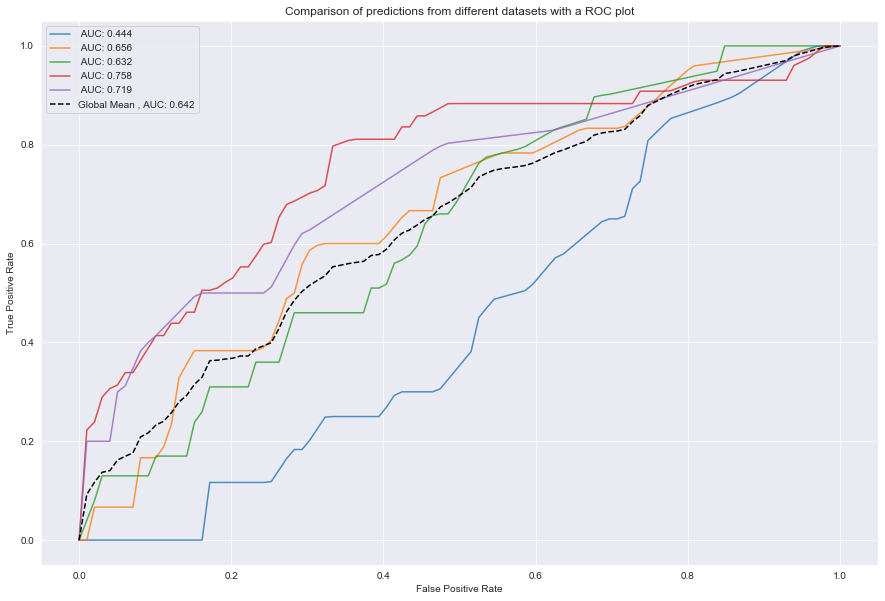

In [74]:
xs_gdpgrowth=[]
ys_gdpgrowth=[]
for i in tab_nmgdp:
    ys_gdpgrowth.append( i['warstds'] )
    xs_gdpgrowth.append( i.drop(['warstds'],axis='columns') )
rocList(clf,xs_gdpgrowth,ys_gdpgrowth,n=5,labels=labs_nmgdp)

## Part Three

In [75]:
#test nmgdp == gdp per capita
cow = doc['cowcode'].unique()

relative=[0]*len(doc)
for country in cow:
    tmp = doc[ doc['cowcode']==country ].sort_values(by='year')
    for year in tmp['year'].unique()[1:]:
        before = tmp[ tmp['year'] == year-1 ]['nmgdp'].values[0]
        after = tmp[ tmp['year'] == year ]['nmgdp'].values[0]
        ratio = (after-before)/before 
        ind=doc.loc[ (doc['year'] == year) & (doc['cowcode'] == country) ].index.values[0] 
        relative[ind]=ratio
doc['evolnmgdp'] = relative

C:\anaconda\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [76]:
doc['evolnmgdp'] = computeEvol(doc,'nmgdp')

C:\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'gdp per capita evolution for each country')

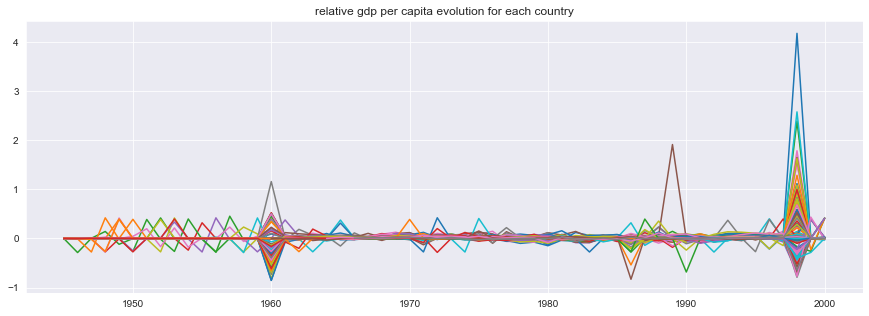

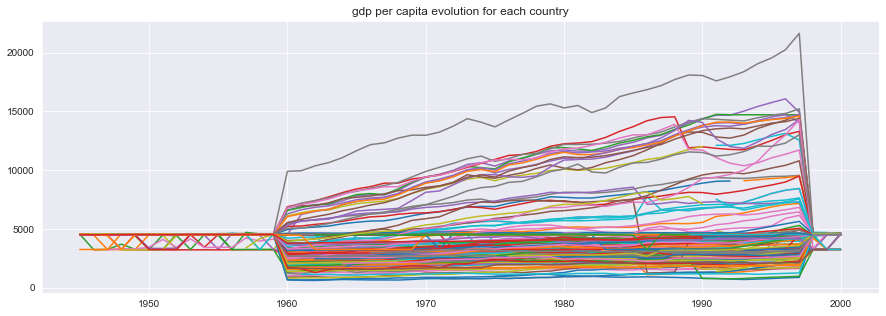

In [77]:
plt.figure(figsize=(15,5))
for country in cow:
    tmp = doc[ doc['cowcode']==country ].sort_values(by='year')
    plt.plot( tmp['year'] , tmp['evolnmgdp'])
    
plt.title('relative gdp per capita evolution for each country')
plt.figure(figsize=(15,5))
for country in cow:
    tmp = doc[ doc['cowcode']==country ].sort_values(by='year')
    plt.plot( tmp['year'] , tmp['nmgdp'])
plt.title('gdp per capita evolution for each country')

-ager
-ptime
-infant
-milper
-trade
-popdense
-gdpgrowth
-fuelexp
-expgdp
-manuexp
-evollife
-illiteracy
-agexp
-sxpsq
-sxpnew
-evolpopdense
-evolexpgdp
-evolnmgdp
-evolinfant
-evolilliteracy


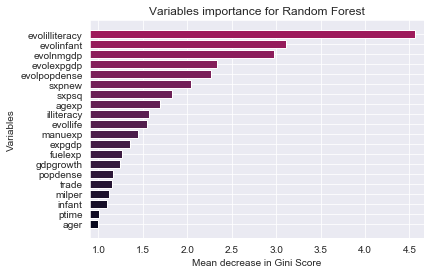

In [78]:
doc_evol=doc.copy()
features=['nmgdp','gdpgrowth','life','infant','expgdp','popdense','illiteracy']
features=['nmgdp','life','infant','expgdp','popdense','illiteracy']
for ft in features:
    doc_evol['evol'+ft] = computeEvol(doc_evol,ft)

#on retire les variables inutiles à la prediction
X = doc_evol.drop(['warstds','year','cowcode'] , axis='columns')
y = doc_evol['warstds']

#perform Random Forest mothod on the data
clf = RandomForestClassifier(n_estimators=100,max_depth=10)
clf.fit(X,y)

#then i match the feature with their importance (aka Gini Score) provided by the Random Forest object
testDF = pd.DataFrame ( { 'variables' : X.columns ,
                          'importance': clf.feature_importances_  ,
                          }  )
#i order the features according to their importance, and keep only the 20 best
testDF = testDF.sort_values(by=['importance'] , ascending=True)[-20:]

#color for the graph, not improtant
palette = sns.color_palette("rocket",n_colors = 50)

#i do a bar plot with the gini score in X axis and name of the features on  Y axis
#note : i 'normalize' the gini score obtained by the minimal value
#i did this first by intuition looking at the original fiure as the gini score start to 1, and the result i obatined were very similar to the figure
plt.barh(testDF['variables'],testDF['importance']/testDF['importance'].min(),color = palette  )
#i set the limit a bit further than the max and min value 
plt.xlim([0.9,testDF['importance'].max()/testDF['importance'].min()+0.1])

#set titles for the figure and the axis
plt.title('Variables importance for Random Forest')
plt.xlabel("Mean decrease in Gini Score")
plt.ylabel("Variables")

#i print the top 20 features (from worst to best) in cases its not readable on the figure
print('-'+'\n-'.join(map(str, testDF['variables'].values)))


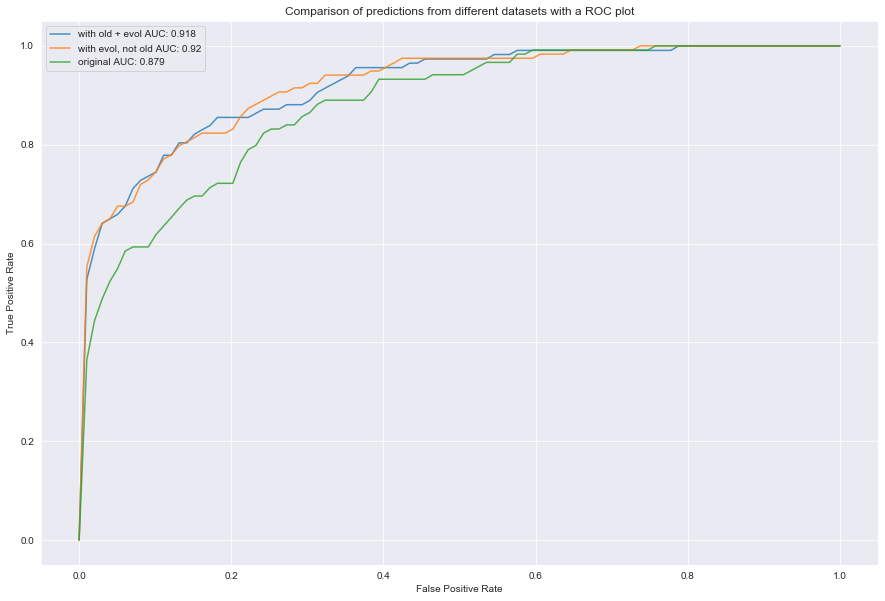

In [79]:
clf = RandomForestClassifier(n_estimators=100, max_depth=10)

X1 = doc_evol.drop(['warstds','year','cowcode','nmgdp','life','infant','expgdp','popdense','illiteracy'] , axis='columns')
X2 = doc_evol.drop(['warstds','year','cowcode','evolnmgdp','evollife','evolinfant','evolexpgdp','evolpopdense','evolilliteracy'] , axis='columns')


Xs = [ X , X1 , X2 ]
Ys = [ y , y , y]
rocList(clf,Xs,Ys,n=10,labels = ['with old + evol','with evol, not old','original'],displaymean = False)

In [83]:
#features=['nmgdp','gdpgrowth','life','infant','expgdp','popdense','illiteracy']

features = ['seceduc', 'pri', 'avgnabo', 'infant', 'ager',
'ptime', 'ln_gdpen', 'nmgdp', 'popdense', 'expgdp',
'lpopns', 'trade', 'manuexp', 'fuelexp', 'milper',
'gdpgrowth', 'illiteracy' ,'agexp', 'sxpsq', 'sxpnew',
'life','terrorism']

scores=[]
clf = RandomForestClassifier(n_estimators=100,max_depth=10)

for ft in features:
    
    doc_copy = doc_t.copy()
    doc_copy['evol'+ft] = computeEvol(doc_copy,ft)
    #print(len(doc_copy.columns))
    
    #on retire les variables inutiles à la prediction
    X = doc_copy.drop(['warstds','year','cowcode'] , axis='columns')
    y = doc_copy['warstds']

    #perform Random Forest mothod on the data
    clf.fit(X,y)

    #then i match the feature with their importance (aka Gini Score) provided by the Random Forest object
    testDF = pd.DataFrame ( { 'variables' : X.columns ,
                              'importance': clf.feature_importances_  ,
                              }  )
    
    #i order the features according to their importance, and keep only the 20 best
    testDF = testDF.sort_values(by=['importance'] , ascending=False)
    testDF = testDF.reset_index()
    
    ind_ft = testDF.loc[ testDF['variables'] == ft].index[0]
    ind_evol = testDF.loc[ testDF['variables'] == 'evol'+ft].index[0]
    
    scores.append( ind_ft - ind_evol )
    


95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95
95


KeyboardInterrupt: 

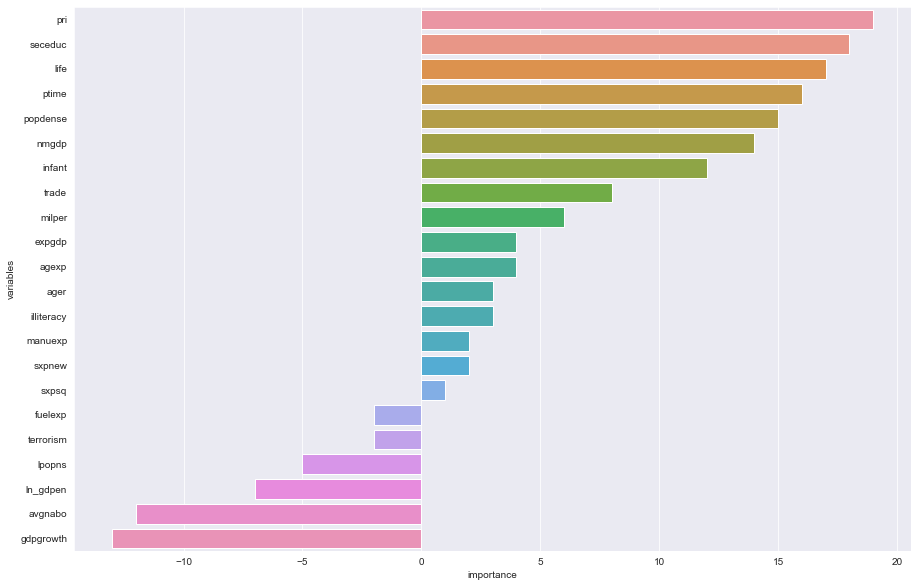

In [82]:
testDF = pd.DataFrame ( { 'variables' : features ,
                              'importance': scores  ,
                              }  )
    
#i order the features according to their importance, and keep only the 20 best
testDF = testDF.sort_values(by=['importance'] , ascending=False)


plt.figure(figsize=(15,10))
sns.barplot(y=testDF['variables'], x=testDF['importance'],)

In [ ]:
features = doc_t.drop( ['warstds','year','cowcode'], axis='columns' ).columns.values

scores=[]
clf = RandomForestClassifier(n_estimators=100,max_depth=10)

for ft in features:
    
    doc_copy = doc_t.drop('country',axis=1).copy()
    doc_copy['evol'+ft] = computeEvol(doc_copy,ft)
    #on retire les variables inutiles à la prediction
    X = doc_copy.drop(['warstds','year','cowcode'] , axis='columns')
    y = doc_copy['warstds']

    #perform Random Forest mothod on the data
    clf.fit(X,y)

    #then i match the feature with their importance (aka Gini Score) provided by the Random Forest object
    testDF = pd.DataFrame ( { 'variables' : X.columns ,
                              'importance': clf.feature_importances_  ,
                              }  )
    
    #i order the features according to their importance, and keep only the 20 best
    testDF = testDF.sort_values(by=['importance'] , ascending=False)
    testDF = testDF.reset_index()
    
    ind_ft = testDF.loc[ testDF['variables'] == ft].index[0]
    ind_evol = testDF.loc[ testDF['variables'] == 'evol'+ft].index[0]
    
    scores.append( ind_ft - ind_evol )
    
testDF = pd.DataFrame ( { 'variables' : features , 'importance': scores  , }  )
    
#i order the features according to their importance, and keep only the 20 best
testDF = testDF.sort_values(by=['importance'] , ascending=False)


In [ ]:
plt.figure(figsize=(15,20))
sns.barplot(y=testDF['variables'], x=testDF['importance'],)
plt.title('Gain in rank of Gini Score for the Evolutions compared to original variables')